# Importing the relevant libraries

In [340]:
import pandas as pd

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,accuracy_score,precision_score,recall_score,roc_curve,roc_auc_score,f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

# Data Preprocessing

## Importing the Database

In [341]:
#import the data from csv file
raw_data = pd.read_csv('ml_datasource.csv')

# Display the first 5 rows of the dataframe for preview

raw_data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [342]:
data = raw_data.copy()
data.shape

(17761, 8)

## Removing Outliers

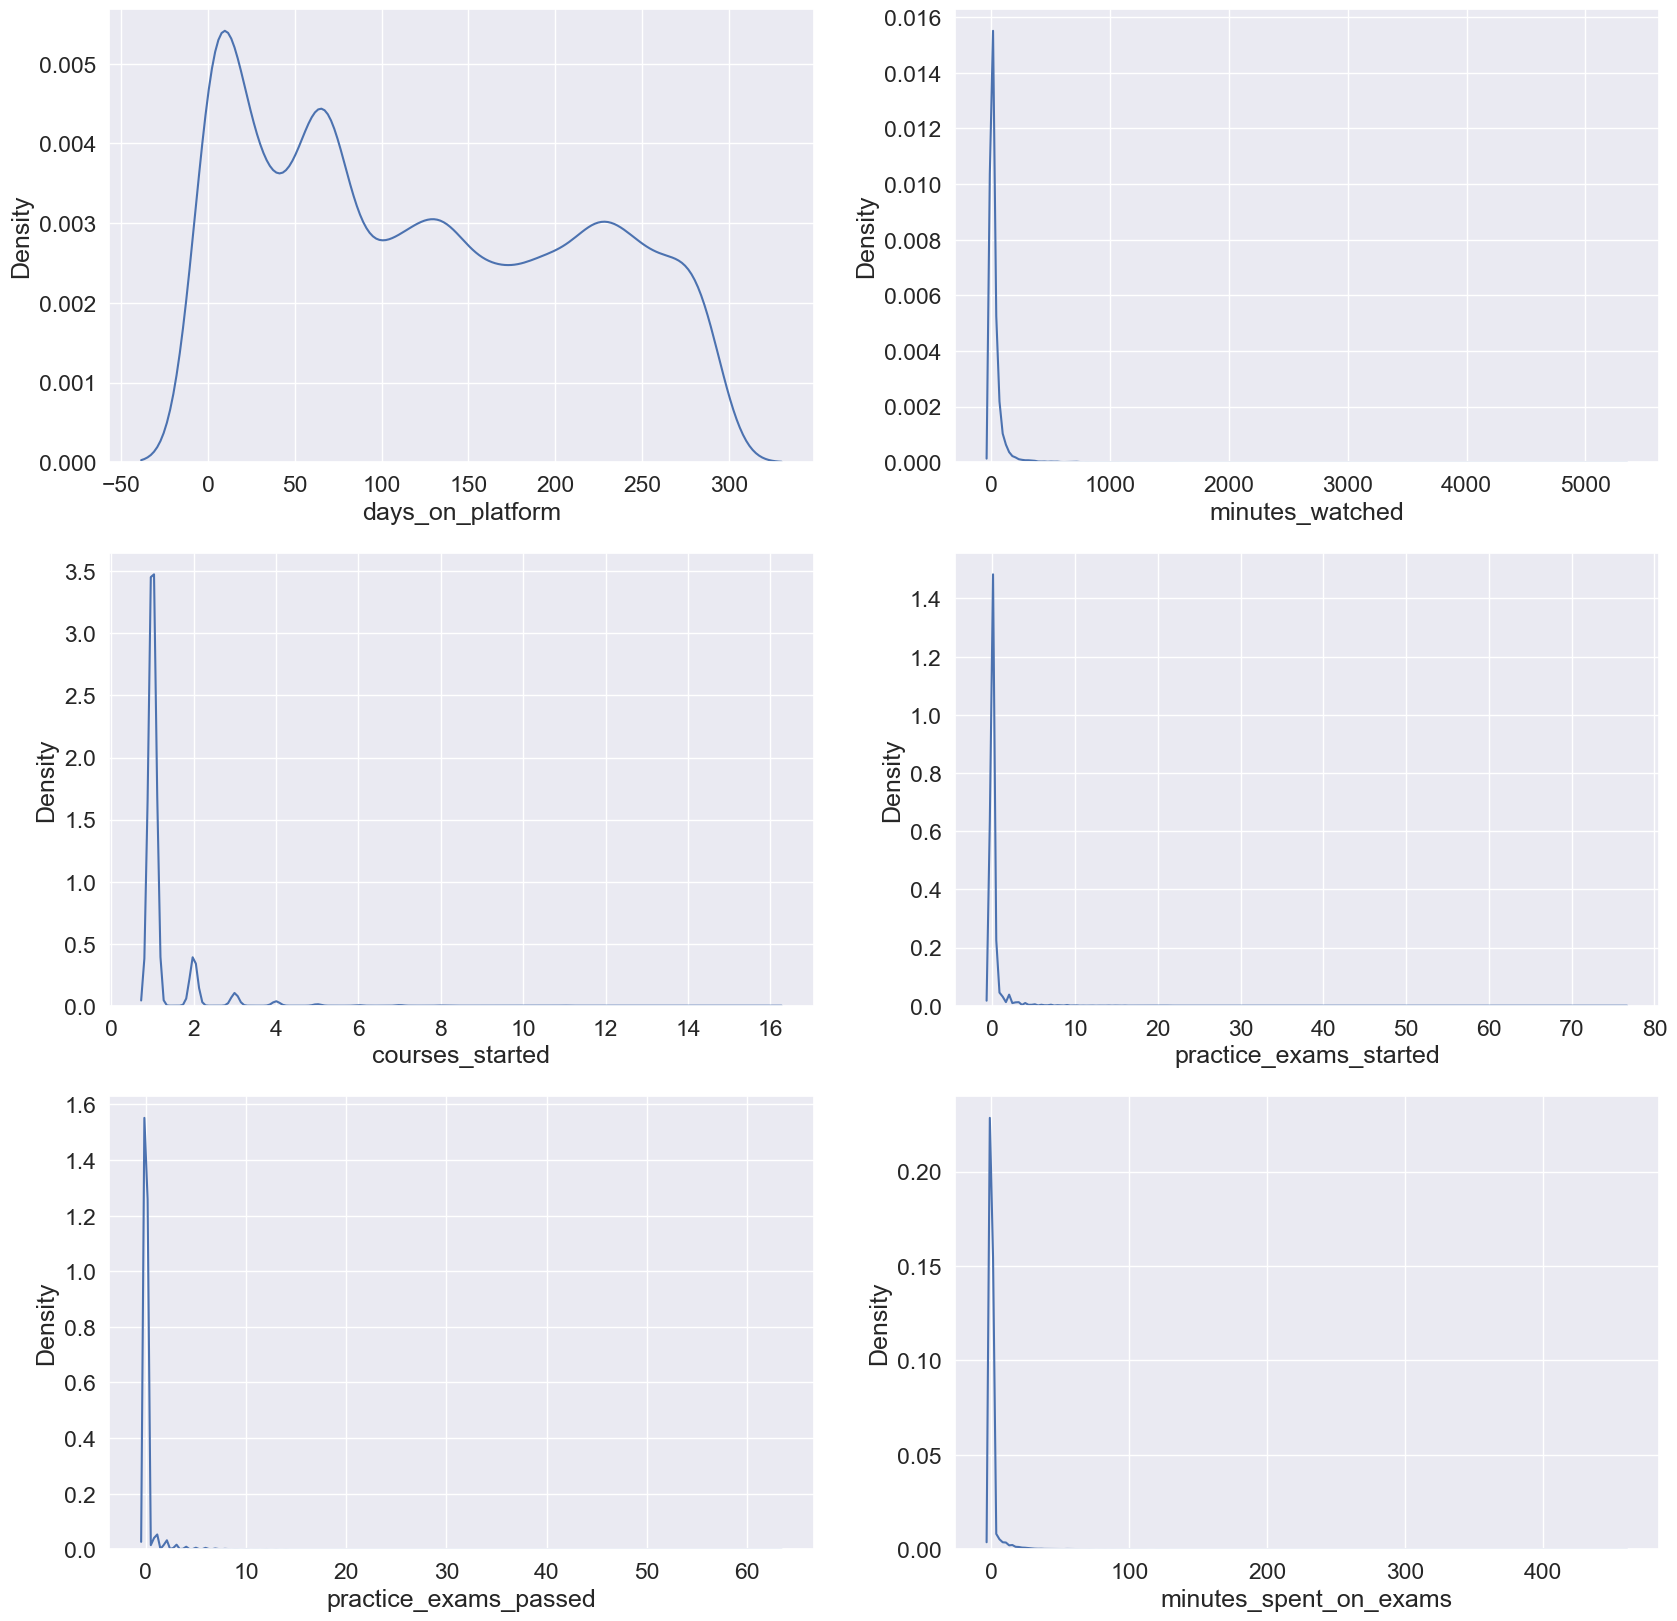

In [343]:
# Reset any modifications to the plotting context (sns) made via seaborn
sns.reset_orig()

#set the font scale for seaborn plots
sns.set(font_scale=1.5)

#initialize a grid of plots with specified dimensions

fig, axes = plt.subplots(3, 2, figsize=(20,20))

# Plotting distribution plots for each of the columns in the dataset

sns.kdeplot(data=data['days_on_platform'], ax=axes[0,0])
sns.kdeplot(data=data['minutes_watched'], ax=axes[0,1])
sns.kdeplot(data=data['courses_started'], ax=axes[1,0])
sns.kdeplot(data=data['practice_exams_started'], ax=axes[1,1])
sns.kdeplot(data=data['practice_exams_passed'], ax=axes[2,0])
sns.kdeplot(data=data['minutes_spent_on_exams'], ax=axes[2,1])

plt.show()

In [344]:
# Removing outliers based on 'minutes_watched', 'courses_started',
# 'practice_exams_started'and 'minutes_spent_on_exams'

data_no_outliers = data[(data['minutes_watched'] <=1000) &
                        (data['practice_exams_started'] <=10) &
                        (data['practice_exams_passed'] <= 10) &
                        (data['minutes_spent_on_exams'] <= 400) &
                        (data['courses_started'] <= 10)]

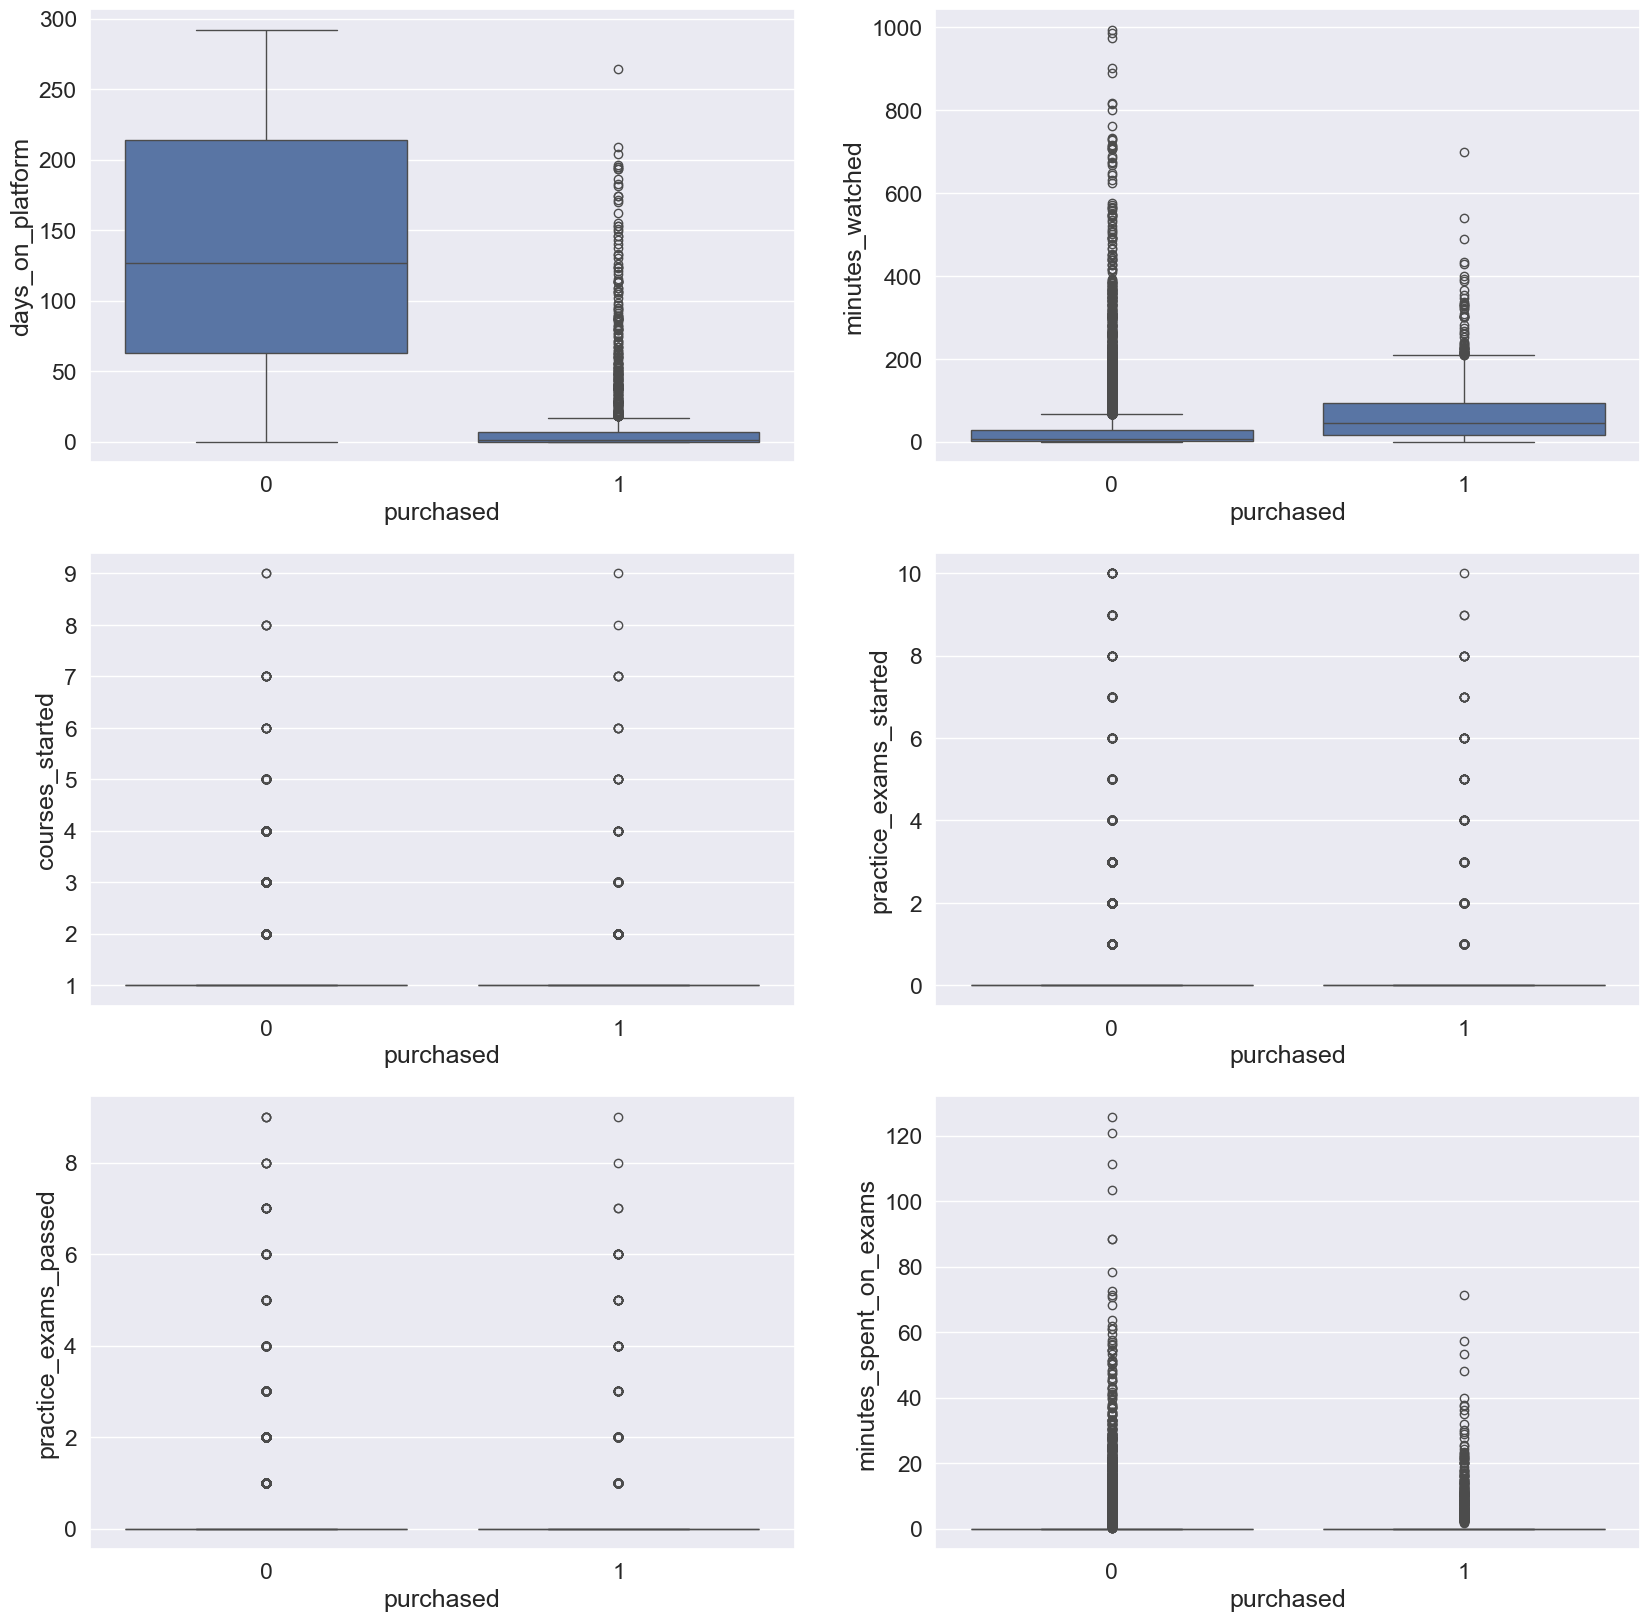

In [345]:
# Plotting box plots for each of the features related to the label(purchased)
feature_cols = ['days_on_platform','minutes_watched',
                 'courses_started','practice_exams_started','practice_exams_passed',
                 'minutes_spent_on_exams']
label_cols = 'purchased'

fig1,axes = plt.subplots(3, 2, figsize=(20,20))

sns.boxplot(data= data_no_outliers,y=feature_cols[0],x=label_cols,ax=axes[0,0])
sns.boxplot(data= data_no_outliers,y=feature_cols[1],x=label_cols,ax=axes[0,1])
sns.boxplot(data= data_no_outliers,y=feature_cols[2],x=label_cols,ax=axes[1,0])
sns.boxplot(data= data_no_outliers,y=feature_cols[3],x=label_cols,ax=axes[1,1])
sns.boxplot(data= data_no_outliers,y=feature_cols[4],x=label_cols,ax=axes[2,0])
sns.boxplot(data= data_no_outliers,y=feature_cols[5],x=label_cols,ax=axes[2,1])

plt.show()

In [346]:
# Plotting bar chart for analyzes purchased in each country
country_purchased_data = data_no_outliers[['student_country','purchased']].groupby(['student_country','purchased']).size().unstack(fill_value=0).reset_index()

country_purchased_data.head()

purchased,student_country,0,1
0,AE,116,22
1,AG,1,0
2,AL,10,1
3,AM,10,2
4,AO,8,0


## Checking for Multicollinearity

In [347]:
# Printing the column names of the dataset (for reference)
data_no_outliers.columns.to_numpy()

array(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started',
       'practice_exams_passed', 'minutes_spent_on_exams', 'purchased'],
      dtype=object)

In [348]:
# Selecting the numerical columns for Variance Inflation Factor (VIF) calculation
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started', 
                              'practice_exams_started', 
                              'practice_exams_passed', 
                              'minutes_spent_on_exams']]

# Creating a DataFrame to store the VIF value for each feature
vif = pd.DataFrame()

# Computing the VIF for each selected feature using list comprehension
# Storing the values in a column called 'VIF'
vif['VIF'] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]

# Storing the names of the features in a column called 'features'
vif['features'] = variables.columns

# Displaying the DataFrame
vif

,VIF,features
0,2.286842,days_on_platform
1,1.871084,minutes_watched
2,3.171459,courses_started
3,10.476791,practice_exams_started
4,8.066381,practice_exams_passed
5,3.057239,minutes_spent_on_exams


In [349]:
# Dropping 'practice_exams_started' to prevent multicollinearity 
data_no_mult = data_no_outliers.drop('practice_exams_started', axis = 1)

# Displaying the first five rows of the new data
data_no_mult.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,15.81,0
1,SG,260,1.7,1,0,16.00,0
2,TR,260,22.4,1,0,0.93,0
3,KE,259,18.8,1,1,14.63,0
4,IN,259,118.0,2,1,16.48,0


In [350]:
# Selecting specific columns for new Variance Inflation Factor (VIF) calculation
variables = data_no_outliers[['days_on_platform',
                              'minutes_watched',
                              'courses_started', 
                              'practice_exams_passed', 
                              'minutes_spent_on_exams']]

# Computing the new VIF values for each selected feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.to_numpy(), i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,2.284108,days_on_platform
1,1.870835,minutes_watched
2,3.160691,courses_started
3,2.371777,practice_exams_passed
4,2.394836,minutes_spent_on_exams


## Dealing with NaN Values

In [351]:
# Checking the number of null values in each column
data_no_mult.isnull().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [352]:
# Select rows from the 'data_no_mult' DataFrame where the 
# 'student_country' column has missing values (NaN).

data_no_mult.loc[data_no_mult['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [353]:
# The only difference is that the student_country
# column in the CSV file reads NA, while in the pandas DataFrame it reads NaN.
# As it turns out, the string NA in database refers to the country code of Namibia.
# But after importing the CSV file into a pandas DataFrame, this country code has been
# translated to NaN.

# Replacing NaN values with the string 'NAMI'
data_no_nulls = data_no_mult.fillna('NAMI', axis = 1)

# Displaying records where 'student_country' is 'NAMI'
data_no_nulls.loc[ data_no_nulls['student_country'] == 'NAMI', 'student_country']

311      NAMI
337      NAMI
556      NAMI
806      NAMI
1097     NAMI
12363    NAMI
12633    NAMI
16946    NAMI
Name: student_country, dtype: object

In [354]:
# Re-checking the number of null values in each column after replacement
data_no_nulls.isnull().sum()

student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

## Splitting the Data

In [355]:
# Defining inputs (feature variables) and target (outcome variable)
inputs = data_no_nulls.drop(['purchased'],axis=1)
target = data_no_nulls['purchased']

In [356]:
# Splitting the data into train test sets, ensuring balanced classes with stratification
x_train, x_test, y_train, y_test = train_test_split(inputs,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify= target)

In [357]:
# Display the first 5 rows of the DataFrame for preview
x_train.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams
11109,IE,113,3.0,1,0,0.0
6780,LK,197,101.1,2,0,0.0
11048,US,114,17.8,1,0,0.0
2493,NG,276,1.4,1,0,0.0
261,ZA,96,86.0,1,1,5.2


## Encoding the Data

In [358]:
# Initializing an ordinal encoder for categorical variables
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value= 171)

# Encoding the 'student_country' column in the training and testing datasets
# and storing the encoded variable in a new column called 'student_country_enc'

x_train['student_country_enc'] = enc.fit_transform(x_train['student_country'].to_numpy().reshape(-1,1))
x_test['student_country_enc'] = enc.transform(x_test['student_country'].to_numpy().reshape(-1,1))

# Dropping the original 'student_country' column after encoding
x_train = x_train.drop(['student_country'], axis=1)
x_test = x_test.drop(['student_country'], axis=1)

# Display first five columns of the encoded training data
x_train.head()


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc
11109,113,3.0,1,0,0.0,69.0
6780,197,101.1,2,0,0.0,87.0
11048,114,17.8,1,0,0.0,158.0
2493,276,1.4,1,0,0.0,112.0
261,96,86.0,1,1,5.2,166.0


In [359]:
# We use the np.asarray() method to ensure data type consistency and compatibility.
# y_train values are converted to integers and x_train values are converted to floating-point numbers.

x_train_array = np.asarray(x_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')

x_test_array = np.asarray(x_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')

# Creating a Logistic Regression Model

In [360]:
# set regularization rate
reg = 0.01

# train a logistic regression model on the training set
log_reg_model = LogisticRegression(C=1/reg, solver= 'liblinear').fit(x_train_array, y_train_array)

# Generating prediction on test set
y_test_pred_log_reg = log_reg_model.predict(x_test_array)

# print Accuracy of the model
print('Accuracy :', accuracy_score(y_test_array, y_test_pred_log_reg))

Accuracy : 0.9502262443438914


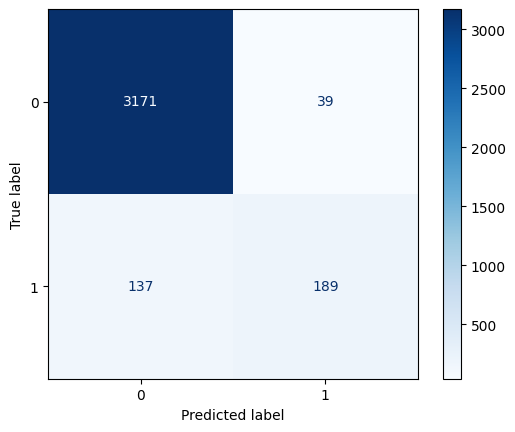

In [361]:
# Resetting any modification to the plotting context made via seaborn
sns.reset_orig()

# Displaying the confusion matrix from the model's predictions
ConfusionMatrixDisplay.from_predictions(
    y_test_array,y_test_pred_log_reg,cmap = 'magma'
)
plt.show()

In [364]:
# Displaying the Classification report
print(classification_report(y_test_array,y_test_pred_log_reg))

# Displaying Overall precision and recall score
print("Overall Precision : ", precision_score(y_test_array,y_test_pred_log_reg))
print("Overall Recall : ", recall_score(y_test_array,y_test_pred_log_reg))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3210
           1       0.83      0.58      0.68       326

    accuracy                           0.95      3536
   macro avg       0.89      0.78      0.83      3536
weighted avg       0.95      0.95      0.95      3536

Overall Precision :  0.8289473684210527
Overall Recall :  0.5797546012269938


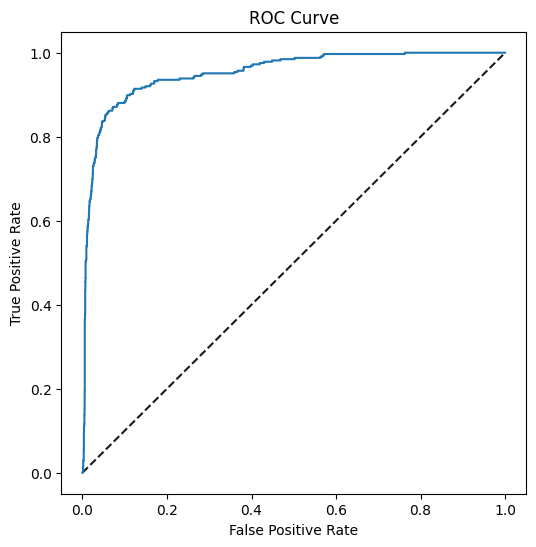

In [365]:
# Calculate ROC Curve
y_scores = log_reg_model.predict_proba(x_test_array)

fpr, tpr, thresholds = roc_curve(y_test_array,y_scores[:,1])
# plot ROC curve
fig2 = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Creating a K-Nearest Neighbors Model

# Creating a Support Vector Machines Model

# Creating a Decision Trees Model

# Creating a Random Forests Model